In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [109]:
cars_df = pd.read_csv(r'data/data.csv')
cars_df = cars_df.rename(columns={"MSRP": "price"})
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  price              11914 non-null  int64  
dtypes: float64(3), int64(5

In [110]:
cars_df.columns = cars_df.columns.str.replace(' ', '_').str.lower()
cars_df.fillna(0, inplace=True)

In [111]:
useful_columns = ["make", 'model', 'year', 'engine_hp', 'engine_cylinders', 'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg']

categorical_columns = []
numerical_columns = []

for col in useful_columns:
    if cars_df[col].dtype == 'object':
        categorical_columns.append(col)
    else:
        numerical_columns.append(col)

print(categorical_columns)
print(numerical_columns)

['make', 'model', 'transmission_type', 'vehicle_style']
['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']


In [112]:
def calc_above_average_price(df: pd.DataFrame) -> pd.DataFrame:
    df['above_average'] = df['price'] > df['price'].mean()
    return df

cars_df = calc_above_average_price(cars_df)

In [113]:
from sklearn.model_selection import train_test_split

# Split the data into train (60%) and temporary set (40%)
train_df, temp_df = train_test_split(cars_df, test_size=0.4, random_state=1)

# Split the temporary set into validation (50%) and test (50%) sets
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=1)

In [114]:
from sklearn.metrics import roc_auc_score

# Compute ROC AUC for each numerical variable
auc_scores = {}
for col in numerical_columns:
    auc = roc_auc_score(train_df['above_average'], train_df[col])
    
    # If AUC is less than 0.5, negate the variable and recompute the AUC
    if auc < 0.5:
        auc = roc_auc_score(train_df['above_average'], -train_df[col])
    
    auc_scores[col] = auc

auc_scores

{'year': 0.6943018002799936,
 'engine_hp': 0.9159001518508375,
 'engine_cylinders': 0.768274900593613,
 'highway_mpg': 0.6333685399678282,
 'city_mpg': 0.67232674562278}

In [115]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

y_train = train_df.above_average.values
y_valid = valid_df.above_average.values
y_test = test_df.above_average.values

full_train_df = train_df.copy()
full_valid_df = valid_df.copy()
full_test_df = test_df.copy()

del train_df['above_average']
del valid_df['above_average']
del test_df['above_average']



In [116]:
print(train_df[categorical_columns + numerical_columns].shape, valid_df[categorical_columns + numerical_columns].shape, test_df[categorical_columns + numerical_columns].shape)

(7148, 9) (2383, 9) (2383, 9)


In [117]:
dv = DictVectorizer(sparse=False)


train_dict = train_df[categorical_columns + numerical_columns].to_dict(orient='records')

valid_dict = valid_df[categorical_columns + numerical_columns].to_dict(orient='records')

test_dict = test_df[categorical_columns + numerical_columns].to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_valid = dv.transform(valid_dict)
X_test = dv.transform(test_dict)

In [118]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [119]:
y_pred = model.predict(X_valid)

In [120]:
y_pred_proba = model.predict_proba(X_valid)[:, 1]

In [121]:
# Compute the AUC
auc = roc_auc_score(y_valid, y_pred)
rounded_auc = round(auc, 3)
rounded_auc

0.921

In [122]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Compute precision and recall for all thresholds
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)

# Include the endpoint for threshold=1.0
thresholds = np.append(thresholds, 1.0)

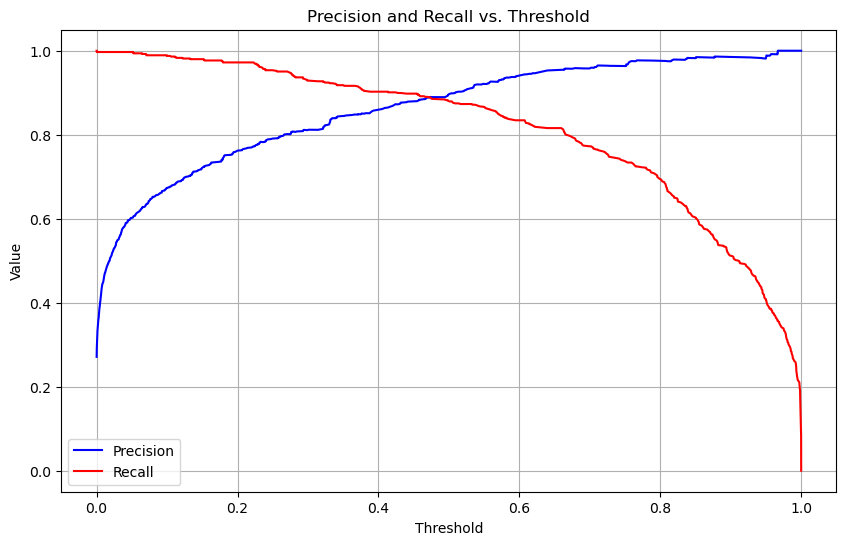

0.47303811363344245

In [123]:
# Plotting precision and recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision, label="Precision", color="blue")
plt.plot(thresholds, recall, label="Recall", color="red")
plt.xlabel("Threshold")
plt.ylabel("Value")
plt.legend()
plt.title("Precision and Recall vs. Threshold")
plt.grid(True)
plt.show()

# Find the threshold where precision and recall intersect
intersect_threshold = thresholds[np.argmin(np.abs(precision - recall))]
intersect_threshold

In [124]:
f1_scores = 2 * (precision * recall) / (precision + recall)

In [125]:
# Find the threshold where F1 is maximal
max_f1_index = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_index]
max_f1_threshold

0.5363105127784017

In [126]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [127]:
from sklearn.model_selection import KFold

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [128]:
# Placeholder for AUC scores
auc_scores = []

In [129]:
full_train_df.reset_index(drop=True)
# Iterate over different folds
for train_index, valid_index in kf.split(full_train_df):

    temp_train_df = full_train_df.iloc[train_index]
    temp_valid_df = full_train_df.iloc[valid_index]
    temp_y_train = temp_train_df.above_average.values
    temp_y_val = temp_valid_df.above_average.values

    dv, model = train(temp_train_df, temp_y_train)
    temp_y_pred = predict(temp_valid_df, dv, model)

    auc = roc_auc_score(temp_y_val, temp_y_pred)
    auc_scores.append(auc)

auc_scores

c:\Users\inris\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inris\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

[0.9780994312970097,
 0.9818422330097087,
 0.9743038172715895,
 0.9832500772479142,
 0.9777376193781565]

In [130]:
# Compute the standard deviation of the AUC scores
std_deviation = np.std(auc_scores)
std_deviation

0.0031808593719795004

In [131]:
from tqdm import tqdm

n_splits = 5
hyper_auc_scores = []
full_train_df.reset_index(drop=True)
# Iterate over different folds

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)


    for train_index, valid_index in kf.split(full_train_df):

        temp_train_df = full_train_df.iloc[train_index]
        temp_valid_df = full_train_df.iloc[valid_index]
        temp_y_train = temp_train_df.above_average.values
        temp_y_val = temp_valid_df.above_average.values

        dv, model = train(temp_train_df, temp_y_train, C=C)
        temp_y_pred = predict(temp_valid_df, dv, model)

        auc = roc_auc_score(temp_y_val, temp_y_pred)
        hyper_auc_scores.append(auc)
    
    print('C=%s %.3f +- %.3f' % (C, np.mean(hyper_auc_scores), np.std(hyper_auc_scores)))



 25%|██▌       | 1/4 [00:03<00:11,  3.76s/it]

C=0.01 0.949 +- 0.005


c:\Users\inris\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 50%|█████     | 2/4 [00:19<00:21, 10.76s/it]

C=0.1 0.960 +- 0.011


c:\Users\inris\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inris\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

C=0.5 0.966 +- 0.013


c:\Users\inris\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inris\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

C=10 0.969 +- 0.013
